# Anant kumar: 2019uce0059
# Chandan Kumar: 2019ucs0094
# Prem Bharti: 2019umt0152
# Sachin Naik: 2019ucs0091

In [125]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [126]:

# Path to the data directory
data_dir = Path("/content/drive/MyDrive/captcha_images_v2/captcha_images_v2")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
print(images)
labels=[]
for img in images:
  labels.append(img.split(os.path.sep)[-1].split(".png")[0])

characters = set()
for label in labels:
  for char in label:
    characters.add(char)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

downsample_factor = 4

max_length =0
for label in labels:
  max_length = max(max_length,len(label))


['/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/226md.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/22d5n.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/2356g.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/23mdg.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/23n88.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/243mm.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/244e2.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/245y5.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/24f6w.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/24pew.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/25257.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/253dc.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/25egp.png', '/content/drive/MyDrive/captcha_images_v2/captcha_images_v2/25m

#Preprocessing

In [127]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    print('Length of Train-Dataset : ',size)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size) #832
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:956]], labels[indices[train_samples:956]]
    x_test, y_test = images[indices[956:]], labels[indices[956:]]
    return x_train, x_valid, y_train, y_valid,x_test, y_test


In [128]:

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# Splitting the data into train,test and validate...
x_train, x_valid, y_train, y_valid,x_test, y_test  = split_data(np.array(images), np.array(labels))

print('Length of Train-Dataset : ',len(x_train))
print('Length of Validation-Dataset: ',len(x_valid))
print('Length of Test-Dataset : ',len(x_test))

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])

    # 5. Transpose the image : left - right
    img = tf.transpose(img, perm=[1, 0, 2])

    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}



Length of Train-Dataset :  1040
Length of Train-Dataset :  832
Length of Validation-Dataset:  124
Length of Test-Dataset :  84



# Create Dataset

In [129]:
#Creating a training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map( encode_single_sample).batch(batch_size))

#Creating a validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = ( validation_dataset.map(encode_single_sample).batch(batch_size))

#Creating a testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = ( test_dataset.map(encode_single_sample).batch(batch_size))


# Visualising the text

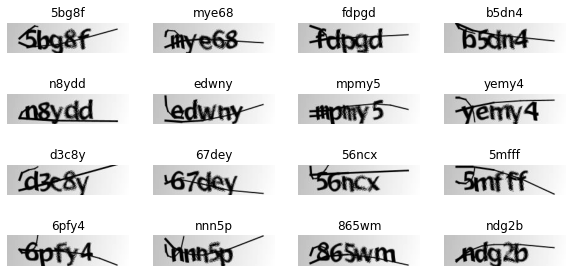

In [130]:
#Printing the training dataset....

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [132]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Runs CTC loss algorithm on each batch element: width and position
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        # The tf.cast() function is used to cast a specified Tensor to a new data type.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        # tf.ones() = Creates a tensor with all elements set to one 
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        # Adding loss for every layer
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",padding="same",name="Conv1",)(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",padding="same",name="Conv2",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

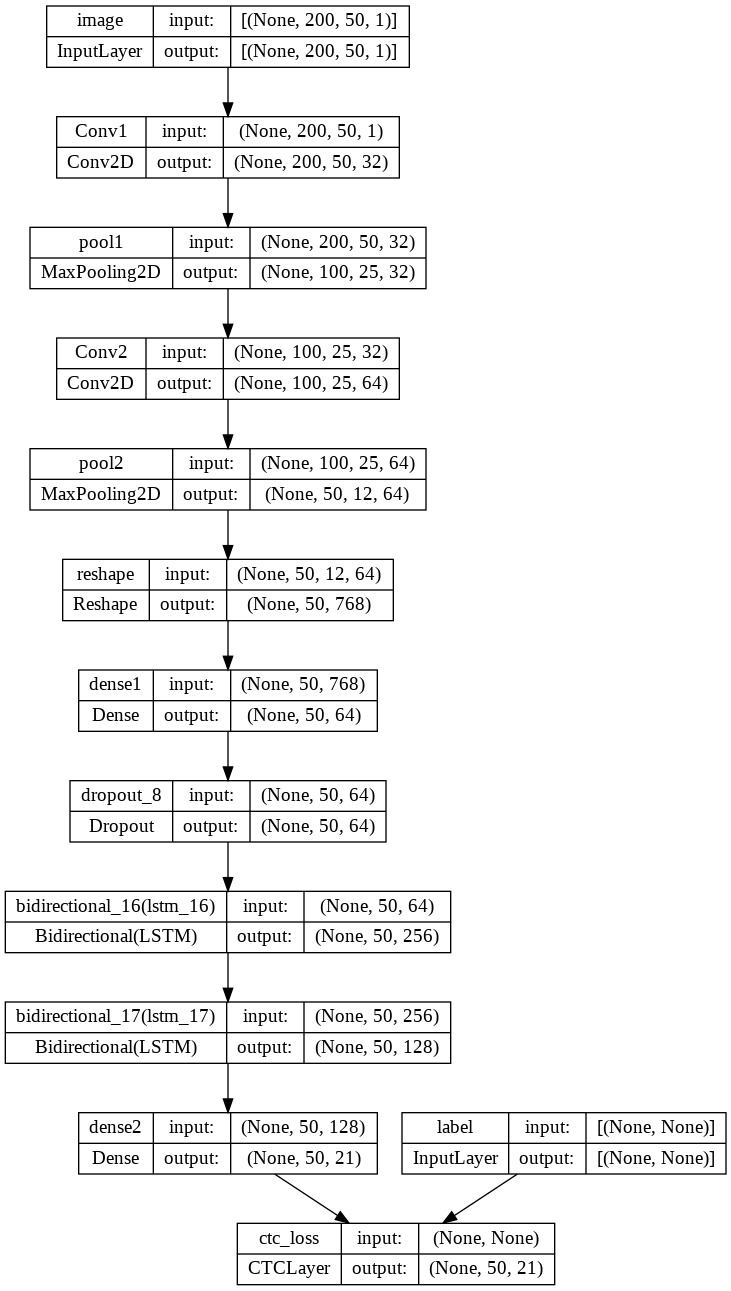

In [133]:
tf.keras.utils.plot_model(model, show_shapes=True)

Training

In [134]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs,callbacks=[early_stopping],)


Epoch 1/100
52/52 [==============================] - 12s 79ms/step - loss: 20.1172 - val_loss: 16.4499
Epoch 2/100
52/52 [==============================] - 3s 57ms/step - loss: 16.3943 - val_loss: 16.3825
Epoch 3/100
52/52 [==============================] - 3s 55ms/step - loss: 16.3866 - val_loss: 16.3797
Epoch 4/100
52/52 [==============================] - 3s 54ms/step - loss: 16.3764 - val_loss: 16.3789
Epoch 5/100
52/52 [==============================] - 3s 58ms/step - loss: 16.3700 - val_loss: 16.3694
Epoch 6/100
52/52 [==============================] - 3s 58ms/step - loss: 16.3593 - val_loss: 16.3570
Epoch 7/100
52/52 [==============================] - 4s 70ms/step - loss: 16.3426 - val_loss: 16.3444
Epoch 8/100
52/52 [==============================] - 4s 76ms/step - loss: 16.3223 - val_loss: 16.3083
Epoch 9/100
52/52 [==============================] - 3s 67ms/step - loss: 16.3008 - val_loss: 16.2515
Epoch 10/100
52/52 [==============================] - 4s 68ms/step - loss: 16.280

# PREDICTING THE MODEL

In [ ]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

orig_texts = []
pred_texts = []
batch_labels=[]

#  Let's check results on testing samples
for batch in test_dataset.take(len(pred_texts)):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

  
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

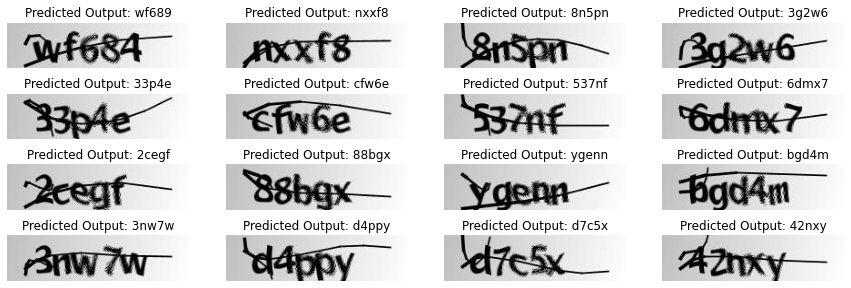

In [148]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T
    title = f"Predicted Output: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()


In [144]:
count =0
for i in range(len(pred_texts)):
  if(pred_texts[i] == y_test[i]):
    count = count +1

print('Accuracy of model is: ',count/len(pred_texts)*100,'%')


Accuracy of model is:  93.75 %
